In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

**Phase 2**

**Code to Reintroduce the Price Column**

In [2]:
# Load the original merged dataset
original_df = pd.read_csv('/kaggle/input/final-merged-dataset/final_merged_df.csv')
refined_features = pd.read_csv('/kaggle/input/dynamic-pricing-refined-features/dynamic_pricing_refined_features_DF.csv')

In [ ]:
print("Columns in original_df:", original_df.columns)
print("Columns in refined_features:", refined_features.columns)


In [ ]:
# Check if indices of the two DataFrames align
are_indices_aligned = original_df.index.equals(refined_features.index)

if are_indices_aligned:
    print("The indices of original_df and refined_features are aligned.")
else:
    print("The indices of original_df and refined_features are not aligned.")
    
    # To understand the mismatch:
    print(f"Original_df index sample: {original_df.index[:5]}")
    print(f"Refined_features index sample: {refined_features.index[:5]}")


In [ ]:
# Merge original_df with refined_features using order_id
# Ensure all rows in refined_features are preserved
if 'order_id' in original_df.columns:
    refined_features_with_price = refined_features.copy()
    refined_features_with_price = refined_features_with_price.merge(
        original_df[['order_id', 'price']],
        left_index=True,  # Assuming indices in refined_features align with original_df
        right_index=True,  # Match on index if no explicit key
        how='left'
    )
    print("Merge successful. 'price' column added to refined features.")
else:
    raise KeyError("The 'order_id' column is missing in original_df.")


In [ ]:
print("Columns in refined_features with price:", refined_features_with_price.columns)

In [ ]:
# Check if the merge was successful
if refined_features_with_price['price'].isnull().any():
    print("Warning: Some rows do not have a matching 'price' value.")
else:
    print("All rows successfully matched with 'price'.")

In [ ]:
# Save the updated refined dataset
refined_features_with_price.to_csv('refined_features_with_price.csv', index=False)
print("Updated refined dataset saved as 'refined_features_with_price.csv'.")

**Generate Synthetic Competitor Pricing Data**

In [ ]:
import numpy as np
import pandas as pd

# Generate synthetic competitor prices
def generate_competitor_prices(df, num_competitors=3, variability=0.1):
    """
    Generate synthetic competitor pricing data.
    """
    competitor_prices = pd.DataFrame(index=df.index)

    for i in range(1, num_competitors + 1):
        col_name = f'competitor_{i}_price'
        # Add variability to the base price
        competitor_prices[col_name] = df['price'] * (1 + np.random.uniform(-variability, variability, size=len(df)))

    return competitor_prices

# Generate the synthetic competitor pricing data
competitor_prices_df = generate_competitor_prices(refined_features_with_price)

# Combine with the existing dataset
dynamic_pricing_data = pd.concat([refined_features_with_price, competitor_prices_df], axis=1)

# Validate the synthetic competitor data
print(dynamic_pricing_data.describe())



In [ ]:
# Check the first 10 rows for 'price', competitor prices, and 'order_id' if it exists
columns_to_check = ['price'] + [col for col in dynamic_pricing_data.columns if 'competitor' in col]

if 'order_id' in dynamic_pricing_data.columns:
    columns_to_check.insert(0, 'order_id')  # Include 'order_id' if it exists in the dataset

# Display the first 10 rows of the selected columns
print(dynamic_pricing_data[columns_to_check].head(10))


In [ ]:
print(dynamic_pricing_data[columns_to_check].isnull().sum())

In [ ]:
# Save the updated dataset for dynamic pricing
dynamic_pricing_data.to_csv('dynamic_pricing_with_competitor_data.csv', index=False)
print("Dynamic pricing dataset with competitor data saved as 'dynamic_pricing_with_competitor_data.csv'.")

In [ ]:
print(dynamic_pricing_data.head(10))

**Verify Data Integrity and Preprocess for Modeling**

In [ ]:
#Reading the CSV file

dynamic_pricing_data = pd.read_csv('/kaggle/input/dynamic-pricing-with-competitor-data/dynamic_pricing_with_competitor_data.csv')

In [ ]:
dynamic_pricing_data.columns

In [ ]:
print(dynamic_pricing_data[['seller_state_sp', 'seller_state_mg','freight_value_log','regional_demand', 'order_id', 'price', 'competitor_1_price',
       'competitor_2_price', 'competitor_3_price']].head(5))

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Identify Numerical and Categorical Columns
print("\n--- Identifying Columns ---")
numerical_cols = ['price', 'competitor_1_price', 'competitor_2_price', 'competitor_3_price']
categorical_cols = [col for col in dynamic_pricing_data.columns if col not in numerical_cols + ['regional_demand', 'order_id']]

# Check if categorical columns are already encoded
already_encoded = any('_' in col for col in categorical_cols)
if already_encoded:
    print("Categorical features appear to be already encoded. Including as is.")
    preprocessed_categorical_cols = categorical_cols
    categorical_cols = []  # No need for further encoding
else:
    print(f"Categorical columns to encode: {categorical_cols}")

# 2. Define Transformers
transformers = [('num', StandardScaler(), numerical_cols)]
if categorical_cols:  # Add encoding only if needed
    transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

# 3. Define Target Variable and Features
target_variable = 'regional_demand'
X = dynamic_pricing_data.drop(columns=[target_variable, 'order_id'])  # Drop target and irrelevant columns
y = dynamic_pricing_data[target_variable]

# 4. Apply Preprocessing Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_processed = pipeline.fit_transform(X)

print("\nPreprocessing completed.")
print(f"Processed feature matrix shape: {X_processed.shape}")

# 5. Confirm Feature Inclusion
print("\nFeatures included in the processed dataset:")
feature_names = preprocessor.get_feature_names_out()
print(feature_names)


**Phase 1 Model and Phase 2 Model**

In [ ]:
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the Saved Model from Phase 1
print("\n--- Loading Saved Model ---")
saved_model_path = '/kaggle/input/phase-1-model/final_random_forest_model.pkl'
try:
    phase1_model = joblib.load(saved_model_path)
    print(f"Model loaded successfully from {saved_model_path}.")
except FileNotFoundError:
    print(f"Error: Model file not found at {saved_model_path}. Ensure Phase 1 has been executed correctly.")
    phase1_model = None

# Step 2: Train-Test Split for Phase 2
print("\n--- Splitting Data for Phase 2 ---")
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
print(f"Training Set Shape: {X_train.shape}, Testing Set Shape: {X_test.shape}")



In [ ]:
# --- Convert Preprocessed Data Back to DataFrame ---
X_test_df = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
print(f"Shape of X_test_df: {X_test_df.shape}")

# Clean column names in X_test_df
cleaned_columns = [col.split('__')[-1] for col in X_test_df.columns]
X_test_df.columns = cleaned_columns

print(f"Cleaned Columns in X_test_df: {X_test_df.columns.tolist()}")

In [ ]:
import pandas as pd

# --- Feature Alignment for Phase 1 Validation ---
phase1_feature_names = phase1_model.feature_names_in_
print(phase1_feature_names)

# Align features for validation
X_test_phase1 = X_test_df[phase1_feature_names]
print(f"Shape of X_test_phase1 (aligned): {X_test_phase1.shape}")

In [ ]:
# Step 3: Validate Phase 1 Model
if phase1_model:
    # Validate the Phase 1 model on aligned data
    print("\nValidating Phase 1 Model on Aligned Phase 2 Dataset...")
    phase1_predictions = phase1_model.predict(X_test_phase1)
    phase1_mae = mean_absolute_error(y_test, phase1_predictions)
    phase1_mse = mean_squared_error(y_test, phase1_predictions)
    phase1_r2 = r2_score(y_test, phase1_predictions)
    print(f"Phase 1 Model Metrics on Phase 2 Test Data:\nMAE: {phase1_mae:.4f}, MSE: {phase1_mse:.4f}, R²: {phase1_r2:.4f}")

# Step 4: Train a Gradient Boosting Model for Dynamic Pricing
print("\n--- Training Gradient Boosting Model ---")
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_gb_model = grid_search.best_estimator_
print(f"\nBest Gradient Boosting Model Parameters: {grid_search.best_params_}")

# Step 5: Evaluate the Gradient Boosting Model
print("\n--- Evaluating Gradient Boosting Model ---")
gb_predictions = best_gb_model.predict(X_test)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)
print(f"Gradient Boosting Model Metrics:\nMAE: {gb_mae:.4f}, MSE: {gb_mse:.4f}, R²: {gb_r2:.4f}")

# Step 6: Visualize Predictions
print("\n--- Visualizing Predictions ---")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gb_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Regional Demand')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Step 7: Save the Gradient Boosting Model
joblib.dump(best_gb_model, 'final_gradient_boosting_model.pkl')
print("\nFinal Gradient Boosting model saved as 'final_gradient_boosting_model.pkl'.")


In [ ]:
phase1_metrics = {
        'MAE': mean_absolute_error(y_test, phase1_predictions),
        'MSE': mean_squared_error(y_test, phase1_predictions),
        'R²': r2_score(y_test, phase1_predictions)
    }

gb_metrics = {
    'MAE': mean_absolute_error(y_test, gb_predictions),
    'MSE': mean_squared_error(y_test, gb_predictions),
    'R²': r2_score(y_test, gb_predictions)
}

In [ ]:
# Compare Metrics
print("\n--- Model Performance Comparison ---")
if phase1_model:
    print(f"Phase 1 Model vs Gradient Boosting Model:")
    print(f"MAE: {phase1_metrics['MAE']:.4f} vs {gb_metrics['MAE']:.4f}")
    print(f"MSE: {phase1_metrics['MSE']:.4f} vs {gb_metrics['MSE']:.4f}")
    print(f"R²: {phase1_metrics['R²']:.4f} vs {gb_metrics['R²']:.4f}")
else:
    print("Comparison unavailable as Phase 1 Model is not loaded.")

**Feature Contribution Analysis**

In [ ]:
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt

# Feature Importance (Permutation)
def plot_permutation_importance(model, X, y, feature_names, title):
    result = permutation_importance(model, X, y, scoring='neg_mean_absolute_error', n_repeats=5, random_state=42)
    sorted_idx = result.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx])
    plt.xlabel("Mean Permutation Importance")
    plt.title(title)
    plt.show()

# Random Forest Feature Importance
plot_permutation_importance(
    phase1_model,
    X_test_phase1,
    y_test,
    phase1_feature_names,
    title="Permutation Importance - Phase 1 Model"
)

# Gradient Boosting Feature Importance
plot_permutation_importance(
    best_gb_model,
    X_test,
    y_test,
    X_test_df.columns,
    title="Permutation Importance - Gradient Boosting Model"
)

# SHAP Analysis for Gradient Boosting
explainer = shap.Explainer(best_gb_model, X_test)
shap_values = explainer(X_test)

print("\n--- SHAP Summary Plot for Gradient Boosting ---")
shap.summary_plot(shap_values, X_test, feature_names=X_test_df.columns)


**Dynamic Pricing Algorithm**

In [4]:
# Load Processed Dataset
dynamic_pricing_data = pd.read_csv('/kaggle/input/dynamic-pricing-with-competitor-data/dynamic_pricing_with_competitor_data.csv')

In [5]:
import numpy as np
import pandas as pd

# Load Gradient Boosting Model
import joblib

#Step 1: Load Phase 2 Model
phase2_model = joblib.load('/kaggle/input/phase-2-model/final_gradient_boosting_model.pkl')

# Step 2: Predict Regional Demand using Gradient Boosting Model
X_features = dynamic_pricing_data.drop(columns=['regional_demand', 'order_id'])
predicted_demand = phase2_model.predict(X_features)

# Add predictions back to the dataset
dynamic_pricing_data['predicted_demand'] = predicted_demand

# Step 3: Define Dynamic Pricing Algorithm
def calculate_optimal_price(row, base_price, margin_target=0.2, competitor_weight=0.5, high_demand_threshold=5000, low_demand_threshold=2000):
    """
    Calculates the optimal price based on demand predictions, competitor prices, and business constraints.
    
    Parameters:
    - row: Single row of the dataset.
    - base_price: The current price of the product.
    - margin_target: Desired profit margin (default: 20%).
    - competitor_weight: Weight assigned to competitor prices (default: 0.5).
    - high_demand_threshold: Threshold to consider demand as high.
    - low_demand_threshold: Threshold to consider demand as low.
    
    Returns:
    - optimal_price: The recommended price.
    """
    # Average competitor price
    competitor_avg_price = np.mean([row['competitor_1_price'], 
                                    row['competitor_2_price'], 
                                    row['competitor_3_price']])
    predicted_demand = row['predicted_demand']

    # Dynamically adjust margin target based on demand
    dynamic_margin = margin_target * (1 + (predicted_demand / high_demand_threshold))
    
    # Adjust pricing based on demand level
    if predicted_demand >= high_demand_threshold:
        # High demand: price slightly higher than base but below competitors
        optimal_price = min(base_price * (1 + dynamic_margin * 0.5), competitor_avg_price * 0.9)
    elif predicted_demand <= low_demand_threshold:
        # Low demand: price slightly lower than base price to boost demand
        optimal_price = max(base_price * (1 - dynamic_margin * 0.2), competitor_avg_price * 1.1)
    else:
        # Moderate demand: balanced pricing between base and competitors
        optimal_price = (base_price * (1 + dynamic_margin) + competitor_avg_price) / 2
    
    # Ensure minimum profit margin
    min_profit_price = base_price * (1 + margin_target)
    return round(max(optimal_price, min_profit_price), 2)

# Step 4: Apply the Pricing Algorithm
base_price = dynamic_pricing_data['price']
dynamic_pricing_data['optimal_price'] = dynamic_pricing_data.apply(
    lambda row: calculate_optimal_price(row, base_price=row['price']), axis=1
)

# Step 5: Evaluate Pricing Strategy
# Revenue with the original prices
original_revenue = np.sum(dynamic_pricing_data['price'] * dynamic_pricing_data['predicted_demand'])

# Revenue with the new optimal prices
optimal_revenue = np.sum(dynamic_pricing_data['optimal_price'] * dynamic_pricing_data['predicted_demand'])

print("\n--- Pricing Strategy Evaluation ---")
print(f"Original Revenue: {original_revenue:.2f}")
print(f"Optimal Revenue: {optimal_revenue:.2f}")

# Save the dataset with optimal prices
dynamic_pricing_data.to_csv('dynamic_pricing_with_optimal_prices.csv', index=False)
print("\nDataset with optimal prices saved as 'dynamic_pricing_with_optimal_prices.csv'.")


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(



--- Pricing Strategy Evaluation ---
Original Revenue: 85511117186.96
Optimal Revenue: 102617153744.88

Dataset with optimal prices saved as 'dynamic_pricing_with_optimal_prices.csv'.


In [6]:

# Load the original dataset
original_df = pd.read_csv('/kaggle/input/final-merged-dataset/final_merged_df.csv')

original_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'product_id', 'seller_id', 'price', 'freight_value', 'payment_type',
       'payment_value', 'product_category_name',
       'product_category_name_english', 'seller_city', 'seller_state',
       'review_score'],
      dtype='object')

In [7]:
# Merge few columns into the dynamic pricing dataset
if 'order_id' in original_df.columns and 'order_id' in dynamic_pricing_data.columns:
    dynamic_pricing_data = dynamic_pricing_data.merge(
        original_df[['order_id', 'product_category_name_english', 'seller_city', 'seller_state']],
        on='order_id',
        how='left'  # Keep all rows in dynamic_pricing_data
    )
    print("Columns successfully added.")
else:
    print("Error: 'order_id' column is missing in one of the datasets.")


# Check for missing values in the dataset
missing_values = dynamic_pricing_data.isnull().sum()

# Filter only the columns with missing values
missing_categories = missing_values[missing_values > 0]

# Display missing value information
if not missing_categories.empty:
    print("\n--- Missing Value Report ---")
    for column, count in missing_categories.items():
        print(f"Warning: {count} rows are missing in the column '{column}'.")
else:
    print("\nAll rows successfully matched, and no missing values detected in any column.")

Columns successfully added.

--- Missing Value Report ---


In [8]:
dynamic_pricing_data.columns

Index(['seller_state_sp', 'seller_state_mg', 'seller_state_pr',
       'freight_value_log', 'seller_state_rj', 'seller_state_sc',
       'seller_city_sao_paulo', 'seller_state_rs', 'seller_city_curitiba',
       'seller_city_rio_de_janeiro', 'seller_city_belo_horizonte',
       'seller_city_maringa', 'seller_state_df', 'seller_city_brasilia',
       'seller_state_ba', 'seller_state_go', 'seller_city_porto_alegre',
       'seller_state_ma', 'seller_state_pe', 'seller_city_sao_luis',
       'seller_city_ibitinga', 'seller_city_petropolis', 'seller_state_es',
       'product_category_name_english_computers_accessories',
       'seller_city_joinville', 'seller_city_lauro_de_freitas',
       'seller_city_recife', 'seller_city_ilicinea',
       'product_category_name_english_health_beauty',
       'seller_city_borda_da_mata', 'seller_city_cariacica',
       'seller_city_brusque', 'seller_city_sao_goncalo',
       'seller_city_blumenau', 'product_category_name_english_bed_bath_table',
       

**Summarizing Prices by Product Category**

In [9]:
# Summarize Prices by Product Category
price_summary = dynamic_pricing_data.groupby('product_category_name_english').agg({
    'price': ['mean'],  # Original Price Statistics
    'competitor_1_price': ['mean'],   # Competitor 1 Statistics
    'competitor_2_price': ['mean'],   # Competitor 2 Statistics
    'competitor_3_price': ['mean'],   # Competitor 3 Statistics
    'optimal_price': ['mean'],  # Optimal Price Statistics
    'predicted_demand': ['mean']  # Predicted Demand
}).reset_index()

# Rename Columns for Readability
price_summary.columns = [
    'Product Category', 
    'Avg Original Price',
    'Avg Competitor 1 Price', 'Avg Competitor 2 Price', 'Avg Competitor 3 Price',
    'Avg Optimal Price',
    'Avg Predicted Demand'
]

# Display Summary Table
print("\n--- Product Category Pricing Summary ---\n")
print(price_summary)



--- Product Category Pricing Summary ---

              Product Category  Avg Original Price  Avg Competitor 1 Price  \
0   agro_industry_and_commerce          280.084854              281.458976   
1             air_conditioning          180.126996              178.337138   
2                          art          106.600375              106.442742   
3        arts_and_craftmanship           68.060000               66.982003   
4                        audio          141.386010              141.405836   
..                         ...                 ...                     ...   
66                  stationery           92.302006               92.433773   
67      tablets_printing_image           90.699063               91.308514   
68                   telephony           69.020773               69.039260   
69                        toys          114.570853              114.720718   
70               watches_gifts          198.494448              198.520358   

    Avg Competitor 2

A pricing summary compares the average original price, competitor prices, optimal price, and predicted demand across categories. This analysis allows businesses to identify how their products are positioned in the market relative to competitors and adjust strategies accordingly.

**Revenue Uplift Comparison Across Product Categories**

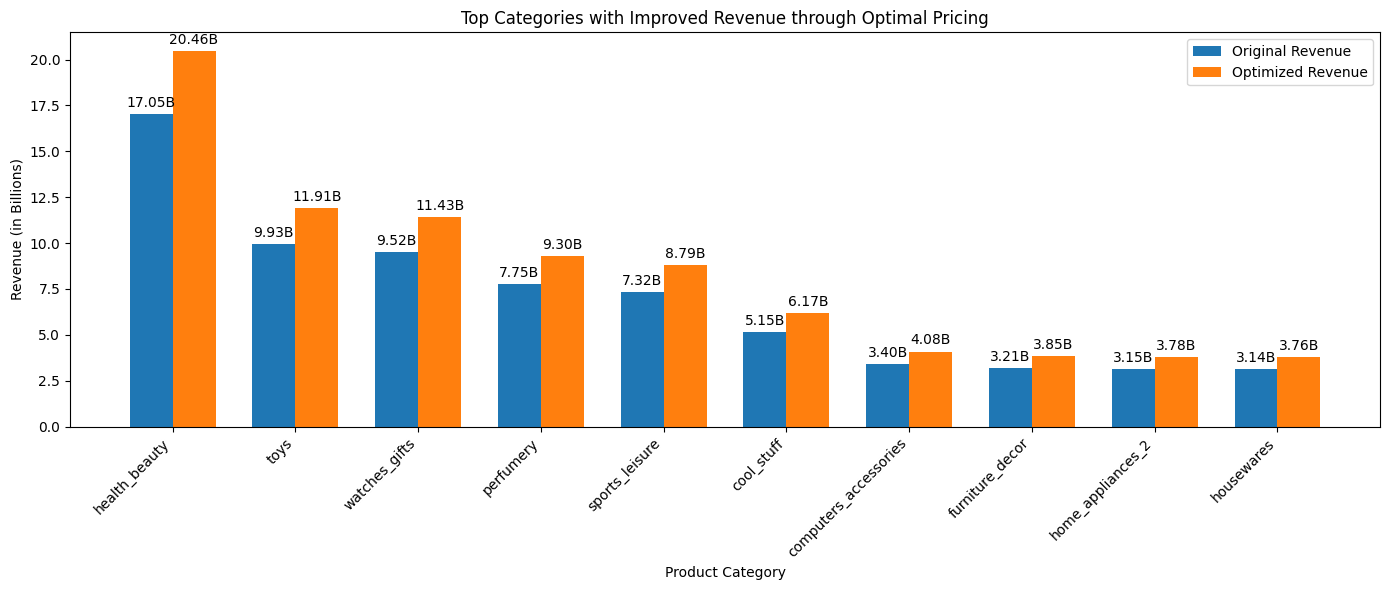

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Group by product category and calculate revenues
category_revenue = dynamic_pricing_data.groupby('product_category_name_english').agg({
    'price': lambda x: np.sum(x * dynamic_pricing_data.loc[x.index, 'predicted_demand']),
    'optimal_price': lambda x: np.sum(x * dynamic_pricing_data.loc[x.index, 'predicted_demand'])
}).reset_index()

category_revenue.columns = ['Product Category', 'Original Revenue', 'Optimized Revenue']

# Filter for top categories with improved revenue
category_revenue['Revenue Improvement'] = category_revenue['Optimized Revenue'] - category_revenue['Original Revenue']
top_improved_categories = category_revenue.nlargest(10, 'Revenue Improvement')

# Convert revenues to billions for better readability
top_improved_categories['Original Revenue (B)'] = top_improved_categories['Original Revenue'] / 1e9
top_improved_categories['Optimized Revenue (B)'] = top_improved_categories['Optimized Revenue'] / 1e9

# Plot the revenue comparison for the top categories
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(top_improved_categories))  # Label locations
width = 0.35  # Bar width

# Bars for Original and Optimized Revenues
original_bars = ax.bar(x - width/2, top_improved_categories['Original Revenue (B)'], width, label='Original Revenue')
optimized_bars = ax.bar(x + width/2, top_improved_categories['Optimized Revenue (B)'], width, label='Optimized Revenue')

# Adding numbers on top of the bars
for bar in original_bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}B',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset for text
                textcoords="offset points",
                ha='center', va='bottom')

for bar in optimized_bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}B',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset for text
                textcoords="offset points",
                ha='center', va='bottom')

# Formatting the plot
ax.set_xlabel('Product Category')
ax.set_ylabel('Revenue (in Billions)')
ax.set_title('Top Categories with Improved Revenue through Optimal Pricing')
ax.set_xticks(x)
ax.set_xticklabels(top_improved_categories['Product Category'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


This representation highlights the impact of dynamic pricing on revenue across product categories. It identifies categories with the highest and lowest revenue uplift, helping businesses focus on strategies for improvement or scaling

**Competitor Price Comparison**

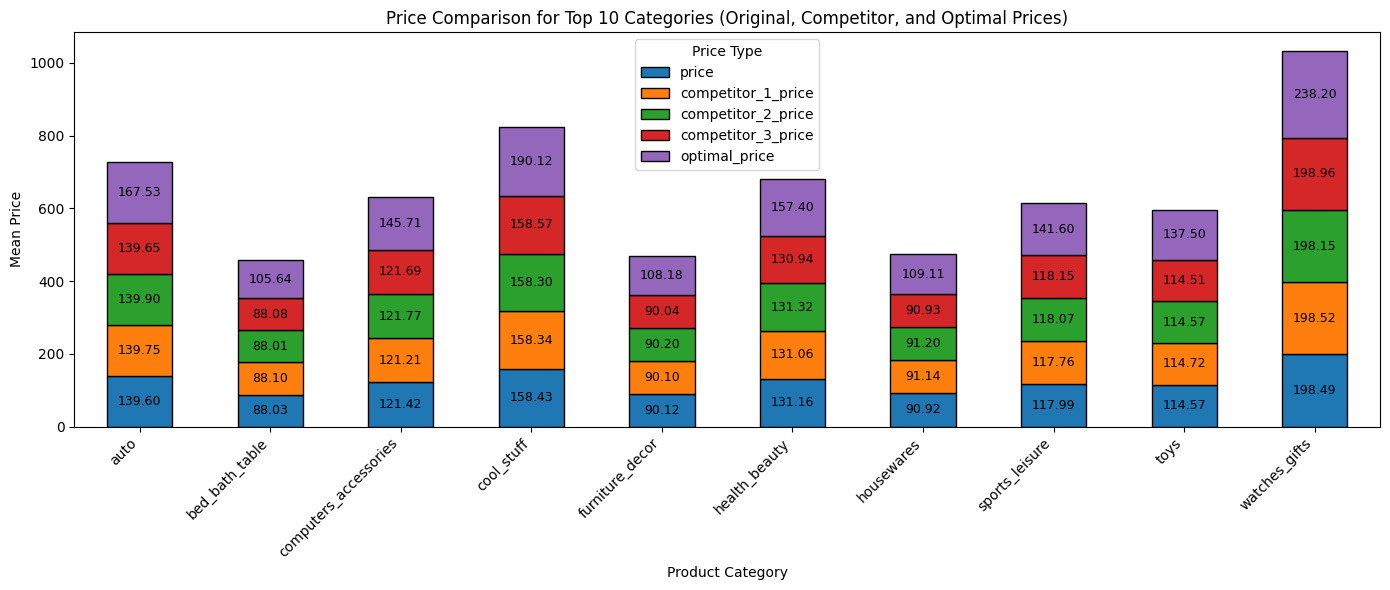

In [11]:
# Adding Original Price to the Competitor Price Comparison

# Filter for top 10 revenue-contributing categories
top_revenue_categories = dynamic_pricing_data.groupby('product_category_name_english')['price'].sum().nlargest(10).index
filtered_data = dynamic_pricing_data[dynamic_pricing_data['product_category_name_english'].isin(top_revenue_categories)]

# Group and aggregate data for the plot
competitor_summary = filtered_data.groupby('product_category_name_english').agg({
    'price': 'mean',  # Original Price
    'competitor_1_price': 'mean',
    'competitor_2_price': 'mean',
    'competitor_3_price': 'mean',
    'optimal_price': 'mean'
}).reset_index()

# Plotting the bar chart with Original Price included
ax = competitor_summary.plot(
    x='product_category_name_english',
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
    edgecolor='black'
)

# Adding values to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=9)

# Customizing the plot
plt.title("Price Comparison for Top 10 Categories (Original, Competitor, and Optimal Prices)")
plt.ylabel("Mean Price")
plt.xlabel("Product Category")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Price Type")
plt.tight_layout()

# Display the plot
plt.show()


This visualization offers critical business insights by directly comparing original prices, competitor prices, and optimal prices across top revenue-contributing product categories. It highlights pricing competitiveness, showing whether products are underpriced or overpriced relative to market standards. By aligning optimal prices with competitor averages, the chart validates the pricing strategy while ensuring profitability. Significant gaps between the optimal and original prices signal opportunities for strategic adjustments, such as justifying higher prices through value communication or leveraging price reductions to capture greater market share. This enables informed, data-driven decisions to balance profitability and competitiveness effectively.

**Detailed Uplift Analysis**

In [12]:
# Assuming `dynamic_pricing_data` is your main DataFrame
# Calculate price uplift
dynamic_pricing_data['price_uplift'] = dynamic_pricing_data['optimal_price'] - dynamic_pricing_data['price']

# Top 10 products with the highest price uplift
top_uplift = dynamic_pricing_data.nlargest(10, 'price_uplift')

# Top 10 products with the lowest price uplift
low_uplift = dynamic_pricing_data.nsmallest(10, 'price_uplift')

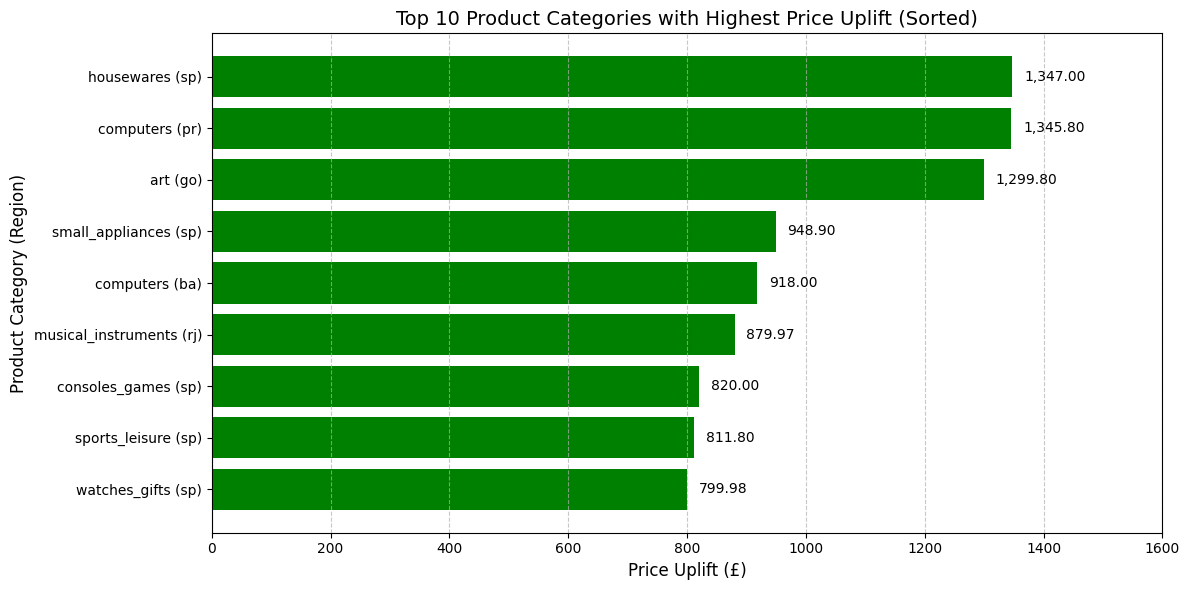

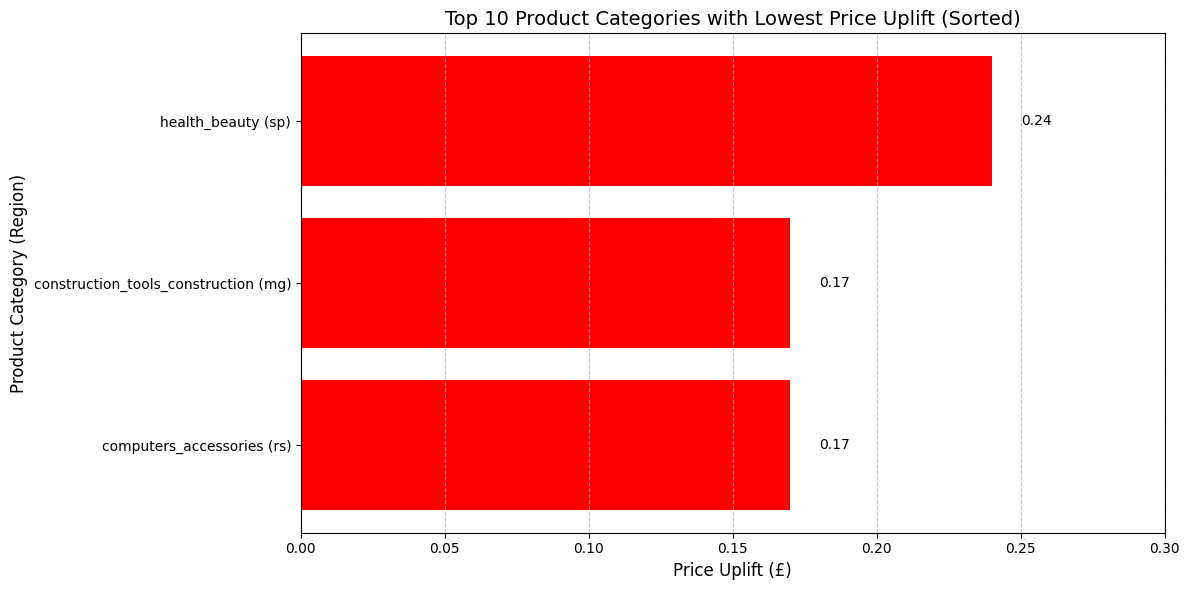

In [13]:
# Aggregate data to resolve duplicate entries
top_uplift_cleaned = top_uplift.groupby(
    ['product_category_name_english', 'seller_state'], as_index=False
).agg({'price_uplift': 'mean'})  # Use mean or sum based on your requirement

low_uplift_cleaned = low_uplift.groupby(
    ['product_category_name_english', 'seller_state'], as_index=False
).agg({'price_uplift': 'mean'})  # Use mean or sum based on your requirement

# Update the labels to combine category and state
top_uplift_cleaned['label'] = top_uplift_cleaned['product_category_name_english'] + ' (' + top_uplift_cleaned['seller_state'] + ')'
low_uplift_cleaned['label'] = low_uplift_cleaned['product_category_name_english'] + ' (' + low_uplift_cleaned['seller_state'] + ')'


# Sort the cleaned data for top uplift in descending order
top_uplift_cleaned_sorted = top_uplift_cleaned.sort_values(by='price_uplift', ascending=True)

# Sort the cleaned data for low uplift in ascending order
low_uplift_cleaned_sorted = low_uplift_cleaned.sort_values(by='price_uplift', ascending=True)

# High Price Uplift Chart (Sorted)
plt.figure(figsize=(12, 6))
bars_high = plt.barh(
    top_uplift_cleaned_sorted['label'],
    top_uplift_cleaned_sorted['price_uplift'], color='green'
)

# Adding value labels outside the bars
for bar in bars_high:
    plt.text(
        bar.get_width() + 20,  # Adjust position
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():,.2f}",
        va='center', fontsize=10
    )

plt.title("Top 10 Product Categories with Highest Price Uplift (Sorted)", fontsize=14)
plt.xlabel("Price Uplift (£)", fontsize=12)
plt.ylabel("Product Category (Region)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, 1600)  # Adjust x-axis range
plt.tight_layout()
plt.show()

# Low Price Uplift Chart (Sorted)
plt.figure(figsize=(12, 6))
bars_low = plt.barh(
    low_uplift_cleaned_sorted['label'],
    low_uplift_cleaned_sorted['price_uplift'], color='red'
)

# Adding value labels outside the bars
for bar in bars_low:
    plt.text(
        bar.get_width() + 0.01,  # Adjust position for small values
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():,.2f}",
        va='center', fontsize=10
    )

plt.title("Top 10 Product Categories with Lowest Price Uplift (Sorted)", fontsize=14)
plt.xlabel("Price Uplift (£)", fontsize=12)
plt.ylabel("Product Category (Region)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, 0.30)  # Adjust x-axis range
plt.tight_layout()
plt.show()


Top 10 Product Categories with Highest Price Uplift:

This visualization identifies the product categories and regions where the dynamic pricing model suggests the most significant price increase. By analyzing these products, businesses can understand which categories are underpriced relative to demand and competitor pricing. This insight helps optimize revenue generation by capturing more value where the demand is high.

Top 10 Product Categories with Lowest Price Uplift:

Highlighting products with the smallest uplift (or even a price decrease) helps businesses recognize where pricing adjustments may be constrained by lower demand or high competition. These products often require strategic discounts or volume-based sales to remain competitive.

**Revenue Contribution**

In [14]:
# Calculate revenue contribution for each product
dynamic_pricing_data['revenue'] = dynamic_pricing_data['optimal_price'] * dynamic_pricing_data['predicted_demand']

# Top uplifted products by revenue contribution
top_revenue_contributors = dynamic_pricing_data.nlargest(10, 'revenue')

# Calculate percentage contribution of top products
total_optimized_revenue = dynamic_pricing_data['revenue'].sum()
top_revenue_contributors['revenue_percentage'] = (top_revenue_contributors['revenue'] / total_optimized_revenue) * 100

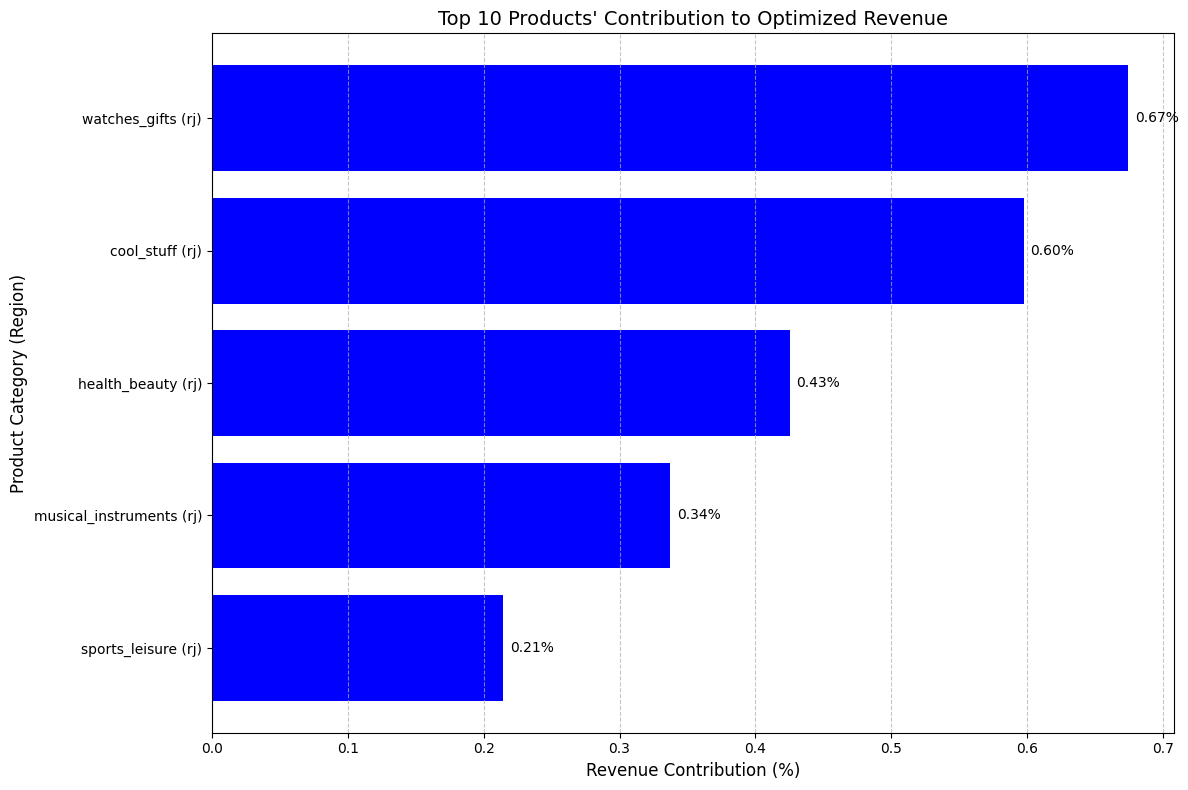

In [15]:
# Aggregate the data to ensure unique product-category combinations
aggregated_data = top_revenue_contributors.groupby(
    ['product_category_name_english', 'seller_state'], as_index=False
).agg({'revenue_percentage': 'sum'})

# Combine the category and state into one label
aggregated_data['label'] = aggregated_data['product_category_name_english'] + ' (' + aggregated_data['seller_state'] + ')'

# Sorting aggregated_data by 'revenue_percentage' in descending order
aggregated_data = aggregated_data.sort_values(by='revenue_percentage', ascending=False)

# Plot the updated data
plt.figure(figsize=(12, 8))
bars = plt.barh(
    aggregated_data['label'],
    aggregated_data['revenue_percentage'], color='blue'
)

# Adding value labels outside the bars
for bar in bars:
    plt.text(
        bar.get_width() + 0.005,  # Slightly offset to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center of the bar
        f"{bar.get_width():.2f}%",  # Format the value as a percentage with two decimals
        va='center', fontsize=10
    )

# Title and labels
plt.title("Top 10 Products' Contribution to Optimized Revenue", fontsize=14)
plt.xlabel("Revenue Contribution (%)", fontsize=12)
plt.ylabel("Product Category (Region)", fontsize=12)

# Invert y-axis for better readability
plt.gca().invert_yaxis()

# Gridlines for improved visibility
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


This representation helps identify the most lucrative product categories and regions. It provides actionable insights into which products and regions drive the most revenue, helping businesses prioritize marketing, inventory, or promotional strategies accordingly.